In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
from step7.Ecommerce7 import*

## Step 3

Experiment n°: 0


Experiment n°: 1


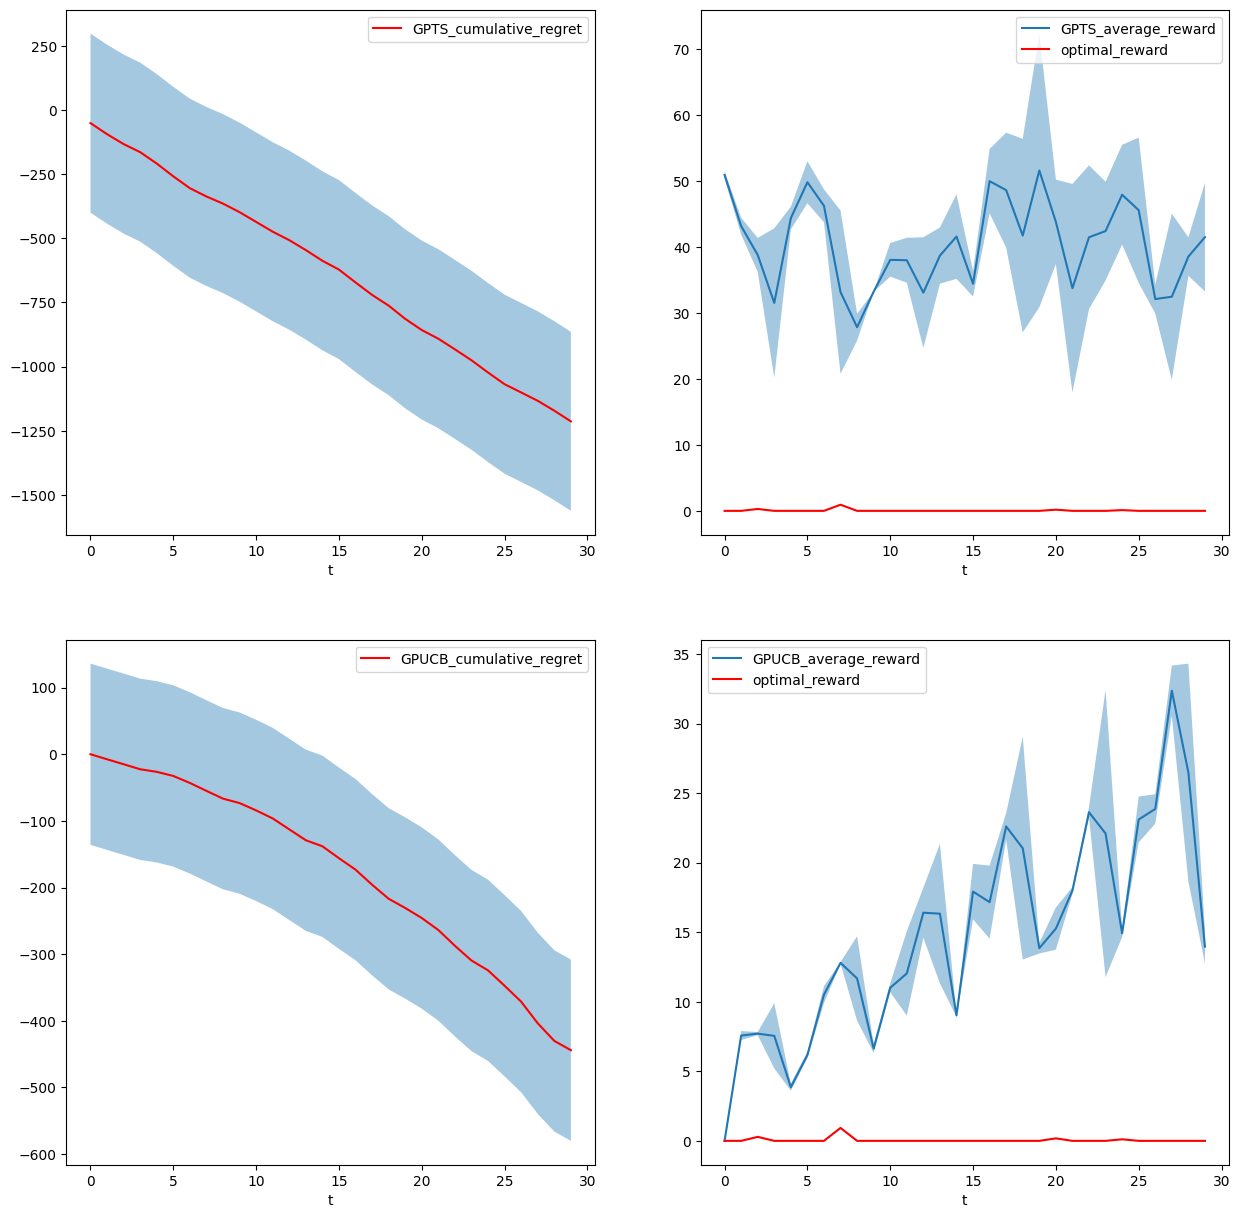

In [3]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"])

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

In [2]:
import numpy as np


In [4]:
matr = np.random.random(size=(5,5))
np.fill_diagonal(matr, val = 1)

In [5]:
arr = np.random.randint(0, 50, size = 5)

In [62]:
np.random.dirichlet([0.02])

array([1.])

In [17]:
env.get_alpha_bars()

array([[5.30809438e-002, 6.53850271e-002, 1.86801649e-002,
        6.86376170e-002, 9.99024318e-002, 2.76471488e-002],
       [5.54964645e-002, 5.18283393e-002, 5.90415789e-002,
        5.70101591e-002, 4.49729749e-002, 6.49838166e-002],
       [2.92977191e-140, 1.00659250e-001, 3.65814251e-002,
        9.16776461e-002, 6.72616566e-002, 3.71533559e-002]])

In [11]:
aggregated_value_per_click = np.random.randint(low =0, high = 10, size = 5)
aggregated_users_alpha = np.ones(shape = (5,10))

In [15]:
np.atleast_2d(aggregated_value_per_click).T.shape

(5, 1)

In [12]:
np.multiply(aggregated_users_alpha,np.atleast_2d(aggregated_value_per_click).T)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]])